# Defect detection using RetinaNet, bounding box technique

## After running the first block of imports go straight to the cell titled:

### "Setup the data for the model"  

In [0]:
# after running this cell restart your runtime
!pip install object-detection-fastai

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')
import json

import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

### for the resizing, defect dot placement and preparing the JASON file

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cbook as cbook
import math
import sys
import imageio
import os
import glob  # used for loading multiple files
# import PIL 
# !mkdir -p /tmp/.cache/torch/checkpoints/
# !cp /input/resnet34/resnet34.pth /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
from pathlib import Path
# from PIL import Image  # if you import it this way you will get attribute error, 
from PIL import Image as PilImage
import cv2
# from fastai import *
# from fastai.vision import *
# from fastai.callbacks.hooks import *
# from fastai.callbacks import SaveModelCallback
# from fastai.metrics import error_rate

# Placing colorcoded dots on defects using the coordinates provided by the data provider

In [0]:
# root directory
path = Path("/content/drive/My Drive/SM/DefectDetection")
# path.ls()

In [0]:
path_train_img = path/'train_images';
path_test_img = path/'test_images';
path_output_img = path/'output_images';

In [0]:
# labels in the train.csv file  this is the table for coordinates of the defects
train = pd.read_csv(path/'train.csv')
train['Label'].unique()

In [0]:
trainA = pd.DataFrame(train[train['Label']=='A'])
trainA.reset_index(inplace=True)
trainB = pd.DataFrame(train[train['Label']=='B'])
trainB.reset_index(inplace=True,)
trainC = pd.DataFrame(train[train['Label']=='C'])
trainC.reset_index(inplace=True)
trainD = pd.DataFrame(train[train['Label']=='D'])
trainD.reset_index(inplace=True)
trainD.shape

In [0]:
# get a list of filenames in the train image directory
fnames = get_image_files(path_train_img)
fnames[0]

### Get a list of path to files

In [0]:
root_path = Path(r"/content/drive/My Drive/SM/DefectDetection")
train_path = root_path/'train_images'
output_path = root_path/'output_images'
test_path = root_path/'test_images'

def path2trainfiles_list(train_path):
    """ Create the list of file names present in Train_set """
    xPath = []
    for files in train_path.iterdir():
        xPath.append(str(files))
    return xPath

xPath = path2trainfiles_list(train_path)

def path2testfiles_list(test_path):
    """ Create the list of file names present in Test_set """
    testPath = []
    for files in test_path.iterdir():
        testPath.append(str(files))
    return testPath

testPath = path2testfiles_list(test_path)

def path2outputfiles_list(output_path):
    """ Create the list of file names present in output_set """
    outPath = []
    for files in output_path.iterdir():
        outPath.append(str(files))
    return outPath

outPath = path2outputfiles_list(output_path)

### Functions to plot small dots on the training image identifying the defects  

### Run this cell just for the first run. to get the files from another directory with A class dots on defects

In [0]:
 # [A, B, C, D]

for i in range(1, len(xPath)+1):

  # img = plt.imread(xPath[i-1])
  # img.shape
  # x = [2237, 1018] # this is the width
  # y = [221, 428]  # this is the hight
 
  x = trainA['X'][trainA['Image_number']==i].values
  y = trainA['Y'][trainA['Image_number']==i].values

  img1 = cv2.imread(xPath[i-1], 1)
  # print(img1.shape)

  for xx,yy in zip(x,y):
    w= img1.shape[1]
    h= img1.shape[0]
    addjustedxx = w-xx
    addjustedyy = h-yy
    img1 = cv2.circle(img1, (addjustedxx, addjustedyy), 3, (255,0,0), 3) #TrainA


  n = os.path.split(xPath[i-1])
  print('n: ',n)
  fname = os.path.splitext(str(n[1]))[0]
  print('fname: ', fname)
  target_num = os.path.splitext(str(n[1]))[0].split('_')[1]
  print('target_num: ',target_num)
  targetpath = os.path.join(output_path,'target_'+target_num+'.png')
  name = 'target_'+target_num+'.png'
  print('dumypath2: ',targetpath)
  
  cv2.imwrite(os.path.join(output_path, name), img1)

  # cv2.destroyAllWindows()

### For the following runs after the first run. to place the dots for defects B, C, D

In [0]:
def path2outputfiles_list(output_path):
    """ Create the list of file names present in Test_set """
    outPath = []
    for files in output_path.iterdir():
        outPath.append(str(files))
    return outPath

outPath = path2outputfiles_list(output_path)

### Make sure the output_path is empty

In [0]:
len(outPath)

In [0]:
 # [A, B, C, D]

# for i in range(1, len(xPath)+1):
for i in range(1, len(outPath)+1):
  # img = plt.imread(xPath[i-1])
  # img.shape
  # x = [2237, 1018] # this is the width
  # y = [221, 428]  # this is the hight
 
  
  x = trainB['X'][trainB['Image_number']==i].values
  y = trainB['Y'][trainB['Image_number']==i].values

  # x = trainC['X'][trainC['Image_number']==i].values
  # y = trainC['Y'][trainC['Image_number']==i].values

  # x = trainD['X'][trainD['Image_number']==i].values
  # y = trainD['Y'][trainD['Image_number']==i].values

  img1 = cv2.imread(outPath[i-1], 1)
  # print(img1.shape)

  for xx,yy in zip(x,y):
    w= img1.shape[1]
    h= img1.shape[0]
    addjustedxx = w-xx
    addjustedyy = h-yy
  
    img1 = cv2.circle(img1, (addjustedxx, addjustedyy), 3, (0,0,255), 3) #TrainB
    # img1 = cv2.circle(img1, (addjustedxx, addjustedyy), 3, (255,242,0), 3) #TrainC
    # img1 = cv2.circle(img1, (addjustedxx, addjustedyy), 3, (0,255,0), 3) #TrainD

  n = os.path.split(outPath[i-1])
  print('n: ',n)
  fname = os.path.splitext(str(n[1]))[0]
  print('fname: ', fname)
  target_num = os.path.splitext(str(n[1]))[0].split('_')[1]
  print('target_num: ',target_num)
  targetpath = os.path.join(output_path,'target_'+target_num+'.png')
  name = 'target_'+target_num+'.png'
  print('dumypath2: ',targetpath)
  
  cv2.imwrite(os.path.join(output_path, name), img1)

  # cv2.destroyAllWindows()

# Resizing images before annotating them in VGG Image Annotator

In [0]:
                                                  
# from PIL import Image                                              
# import os, sys                       

# path = Path(r"/content/drive/My Drive/SM/DefectDetection/Training_images_resized")

# def resize_imgs():
#     for item in path.iterdir():
#       im = Image.open(item)
#       f, e = os.path.splitext(item)
#       # print(e)
#       imResize = im.resize((1024,1024), Image.ANTIALIAS)
# #       imResize = im.resize((2048,2048), Image.ANTIALIAS)
#       imResize.save(f+'.png', 'png')#, quality=80)

# resize_imgs()

# Reformating the cocoformat jason file that was exported from VIA software to a format that can be used in RetinaNet architecture

In [0]:
path = Path('/content/drive/My Drive/SM/DefectDetection/data/SM_sample')
list(path.iterdir())

In [0]:
# # this jason file shows the correct format, So I followed its format
# data1 = json.load((path/'train_sample - coco.json').open()) 
# data1.keys()

dict_keys(['categories', 'annotations', 'images'])

In [0]:
# My jason file to be formated 

datapath = 'annotations'
data2 = json.load((path/datapath/'Sm_defect_BBdiffcolour_cocFormat.json').open())
data2.keys()

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])

# My own method of cleaning up the JASON file

In [0]:
data2.pop('info', None)
data2.pop('licenses', None)
data2.keys()

dict_keys(['images', 'annotations', 'categories'])

### Category key

In [0]:
len(data2['categories']) # long list

In [0]:
data2['categories'][30]

In [0]:
data2['categories'] = [{'id': 1, 'name': 'A'}, {'id': 2, 'name': 'B'}, {'id': 3, 'name': 'C'}, {'id': 4, 'name': 'D'}]

In [0]:
data2['categories']

[{'id': 1, 'name': 'A'},
 {'id': 2, 'name': 'B'},
 {'id': 3, 'name': 'C'},
 {'id': 4, 'name': 'D'}]

### Image Key

In [0]:
i=0
data2['images'][i]

{'date_captured': '',
 'file_name': 'target_1.png',
 'height': 1024,
 'id': 0,
 'license': 1,
 'width': 1024}

In [0]:
image_keys2 = ['file_name', 'id'] # The keys you want
for i in range(len(data2['images'])):
  data2['images'][i] = dict((k, data2['images'][i][k]) for k in image_keys2 if k in data2['images'][i])
  # print(data2['images'][i])

In [0]:
i=0
data2['images'][i]

{'file_name': 'target_1.png', 'id': 0}

### match the id and file_name

In [0]:
for i in range(len(data2['images'])):
  fnum = data2['images'][i]['file_name'].split('.')[0].split("_")[1]
  data2['images'][i]['id'] = fnum
  # fname = fname.split('.')[0].split("_")[1]
  # print(fname)                                      
  # print(data2['images'][i]['id'])
  # data2['images'][i]['id'] +=1

### Adding 1 to match the id and filename if needed

In [0]:
# for i in range(len(data2['images'])):
#   # print(data2['images'][i]['id']+1)
#   data2['images'][i]['id'] +=1

In [0]:
data2['images'][10]

{'file_name': 'target_11.png', 'id': '11'}

In [0]:
# image_keys2 = ['file_name', 'id'] # The keys you want
# data2['images'] = dict((k, data2['images'][k]) for k in image_keys2 if k in data2['images'])

### Annotation Key

In [0]:
data2['annotations']  # bbox list[column, row, height, width]

In [0]:
annot_keys2 = [ 'image_id','bbox', 'category_id']# The keys you want
for i in range(len(data2['annotations'])):
  data2['annotations'][i] = dict((k, data2['annotations'][i][k]) for k in annot_keys2 if k in data2['annotations'][i])
  # print(data2['annotations'][i])

In [0]:
# len(data2['annotations'])
data2['annotations']

In [0]:
for i in range(len(data2['annotations'])):
  data2['annotations'][i]['image_id'] = int(data2['annotations'][i]['image_id'])

In [0]:
data2['annotations'][0]

{'bbox': [212, 74, 74, 61], 'category_id': 1, 'image_id': 0}

In [0]:
 type(data2['annotations'][0]['image_id'])

int

In [0]:
# annot_keys2 = ['bbox', 'category_id', 'image_id']# The keys you want
for i in range(len(data2['annotations'])):
  # data2['annotations'][i] = dict((k, data2['annotations'][i][k]) for k in annot_keys2 if k in data2['annotations'][i])
  print(data2['annotations'][i])

In [0]:
data2['annotations'][0]['image_id']

### adding 1 to fix the image id start from 1 not zero

In [0]:
for i in range(len(data2['annotations'])):
  # print(str(int(data2['annotations'][i]['image_id'])+1))
  data2['annotations'][i]['image_id'] = int(data2['annotations'][i]['image_id'])+1

In [0]:
data2['annotations'][0]

{'bbox': [212, 74, 74, 61], 'category_id': 1, 'image_id': 1}

### probably wouldn't matter but I like them to have the same order 

In [0]:
data2.keys()

dict_keys(['images', 'annotations', 'categories'])

In [0]:
data2_keys = ['categories', 'annotations', 'images']# The keys you want
data2 = dict((k,data2[k]) for k in data2_keys)

In [0]:
data2.keys()

dict_keys(['categories', 'annotations', 'images'])

## Save the new JASON file

In [0]:
with open('/content/drive/My Drive/SM/DefectDetection/data/SM_sample/annotations/Sm_defect_BBdiffcolour_cocFormat_modified.json', 'w') as fp:
    json.dump(data2, fp)

# Trying the format structure made by Howard in FastAi course, notebook Pascal  
https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb  

In [0]:
# My jason file to be formated 
path = Path('/content/drive/My Drive/SM/DefectDetection/data/SM_sample')
# list(path.iterdir())
datapath = 'annotations'
data2 = json.load((path/datapath/'Sm_defect_BBdiffcolour_cocFormat.json').open())
data2.keys()

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])

In [0]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
data2[IMAGES][:2]

[{'date_captured': '',
  'file_name': 'target_1.png',
  'height': 1024,
  'id': 0,
  'license': 1,
  'width': 1024},
 {'date_captured': '',
  'file_name': 'target_2.png',
  'height': 1024,
  'id': 1,
  'license': 1,
  'width': 1024}]

In [0]:
data2[ANNOTATIONS][:2]

[{'area': 4514,
  'bbox': [212, 74, 74, 61],
  'category_id': 1,
  'id': 0,
  'image_id': '0',
  'iscrowd': 0,
  'segmentation': [212, 74, 286, 74, 286, 135, 212, 135]},
 {'area': 5328,
  'bbox': [106, 74, 72, 74],
  'category_id': 1,
  'id': 1,
  'image_id': '0',
  'iscrowd': 0,
  'segmentation': [106, 74, 178, 74, 178, 148, 106, 148]}]

In [0]:
for i in range(len(data2[ANNOTATIONS])):
  data2[ANNOTATIONS][i]['image_id'] = int(data2[ANNOTATIONS][i]['image_id'])

In [0]:
for i in range(len(data2[ANNOTATIONS])):
  # print(str(int(data2[ANNOTATIONS][i]['image_id'])+1))
  data2[ANNOTATIONS][i]['image_id'] = int(data2[ANNOTATIONS][i]['image_id'])+1

In [0]:
data2[ANNOTATIONS][:2]

[{'area': 4514,
  'bbox': [212, 74, 74, 61],
  'category_id': 1,
  'id': 0,
  'image_id': 1,
  'iscrowd': 0,
  'segmentation': [212, 74, 286, 74, 286, 135, 212, 135]},
 {'area': 5328,
  'bbox': [106, 74, 72, 74],
  'category_id': 1,
  'id': 1,
  'image_id': 1,
  'iscrowd': 0,
  'segmentation': [106, 74, 178, 74, 178, 148, 106, 148]}]

In [0]:
data2[CATEGORIES][:4]

[{'id': 1, 'name': 'A', 'supercategory': 'shape'},
 {'id': 2, 'name': 'B', 'supercategory': 'shape'},
 {'id': 3, 'name': 'C', 'supercategory': 'shape'},
 {'id': 4, 'name': 'D', 'supercategory': 'shape'}]

In [0]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in data2[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in data2[IMAGES]}
trn_ids = [o[ID] for o in data2[IMAGES]]

In [0]:
imagepath = 'train_sample'

In [0]:
IMG_PATH = path/imagepath
list(IMG_PATH.iterdir())[:5]

In [0]:
for i in range(len(data2[IMAGES])):
  # print(data2[IMAGES][i][ID]+1)
  data2[IMAGES][i][ID] +=1

In [0]:
im0_d = data2[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('target_1.png', 1)

### defaultdict intro  
#### "The standard dictionary includes the method setdefault() for retrieving a value and establishing a default if the value does not exist. By contrast, defaultdict lets the caller specify the default(value to be returned) up front when the container is initialized."  
Initialize defaultdict by passing a callable as its first argument(mandatory)

In [0]:
# data2[ANNOTATIONS][0][BBOX] -> x(columns), y(rows), w , h

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])  # map the bbox coords: [Rows, columns, topleft, bottomright]
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])       # inverse function for later 

trn_anno = collections.defaultdict(lambda:[]) # enter an empty list if calling a key that doesnt exit yet
for o in data2[ANNOTATIONS]:                  
    # if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)                        # map bbox
        # print(o[IMG_ID])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID])) # for each image id, append all instances of (bb and category_id), and if o[IMG_ID] doesnt exit create it as []
        
# len(trn_anno)



In [0]:
data2.pop('info', None)
data2.pop('licenses', None)
data2.keys()

dict_keys(['images', 'annotations', 'categories'])

In [0]:
with open('/content/drive/My Drive/SM/DefectDetection/data/SM_sample/annotations/Sm_defect_BBdiffcolour_cocFormat_FASTAImodified.json', 'w') as fp:
    json.dump(data2, fp)

In [0]:
######################################################################################################################################################################################################################

In [0]:
######################################################################################################################################################################################################################

# Setup the data for the model  


In [0]:
path = Path('/content/drive/My Drive/SM/DefectDetection/data/SM_sample')
list(path.iterdir())

In [0]:
data2 = json.load((path/'annotations/Sm_defect_BBdiffcolour_cocFormat_FASTAImodified.json').open()) #/content/drive/My Drive/SM/DefectDetection/data/SM_sample/annotations/train_sample_cocoFormat_modified.json
data2.keys()

dict_keys(['images', 'annotations', 'categories'])

## Function to get the annotations from JASON file  


In [0]:
''' this line shows all image names collected by the jason export from VGG Image Annotator.'''
# l = [data2['images'][i]['file_name'] for i in range(len(data2['images']))]
''' this line shows that not all images do have annotations, which is not what happend when I annotated all images. anyways, I prefer to catch this before creating the data block '''
# l = [data2['annotations'][i]['image_id'] for i in range(len(data2['annotations']))]

In [0]:
def annotation_maper(fname, prefix=None):
    " Returns the lists of filenames (with maybe `prefix`) and labelled bounding boxes."
    # pdb.set_trace()
    annot_dict = json.load(open(fname))
    l = [annot_dict['images'][i]['file_name'] for i in range(len(annot_dict['images']))]
    # print(annot_dict)
    # print(annot_dict.keys())
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list) 
    # A defaultdict is useful any time you want to have a default dictionary entry for new keys.
    # if you are trying to access a key that doesnt exist it makes itself exist and set its value 
    # to the func inside the parantesesi in this case the list
    classes = {}
    for o in annot_dict['categories']:
        # print(o)
        classes[o['id']] = o['name']
    
    for o in annot_dict['annotations']:
    
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[1],bb[0], bb[3]+bb[1], bb[2]+bb[0]])    # pay attention to this line
    # print(id2bboxes)
        id2cats[o['image_id']].append(classes[o['category_id']])

    # # print(id2cats)
    for o in annot_dict['images']:
      # print(o)
        if o['id'] in id2bboxes:
            id2images[o['id']] = ifnone(prefix, '') + o['file_name']
    ids = list(id2images.keys())
    # print(ids)
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]


#### Grab the bbox annotations and zip them in a dictionary with their respective image names from the data. 

In [0]:
# images, lbl_bbox = get_annotations(path/'annotations/Sm_defect_BBdiffcolour_cocFormat_FASTAImodified.json')
# img2bbox = dict(zip(images, lbl_bbox))
# get_y_func = lambda o:img2bbox[o.name]

images, lbl_bbox = annotation_maper(path/'annotations/Sm_defect_BBdiffcolour_cocFormat_FASTAImodified.json')

In [0]:
img2bbox = dict(zip(images, lbl_bbox))

""" writing it in func format. in case later I want to add stuff to it otherwise one line get_y_func= lambda o:img2bbox[o.name] should do it"""
def get_y_lambda_func(img2bbox=img2bbox):
    return lambda o:img2bbox[o.name]

get_y_func = get_y_lambda_func(img2bbox)

#### The following two cells will remove image files in train_sample that VGG Image Annotator for some stupid reason failed to export the annotation bboxes for.   
#### so assure you have a copy of train_sample images elsewhere before running the following cells

In [0]:
annot_image_list = list(img2bbox.keys())
train_image_list = [x.name for x in imgpath.iterdir()]
# l = list(set(train_image_list)-set(annot_image_list))  # i have to look further into this line
in_trainfolder_notin_annot = [x for x in train_image_list if x not in annot_image_list] # but this works for sure

In [0]:
for fname in in_trainfolder_notin_annot: 
    try:
        os.remove(os.path.join(imgpath, fname))
    except OSError:
        pass

In [0]:
size =  1024  # this is the size that was used durring the creation of bboxes in VIA
bs = 6

#### Explore transform(), remember to make sure bounding boxes are transformed as well. this doesnt mean they get rotated or sheared, makes sure bbox doesn't relocate away from its object 

In [0]:
xtfms = []  # add your extra transforms here
data = (ObjectItemList.from_folder(imgpath)
        # get the images from path folder
        .split_by_rand_pct(valid_pct= 0.1, seed= 101)                          
        # random split of dataset to train/val
        .label_from_func(get_y_func)
        # find the labels using get_y_func on the file_name of the images
        # .transform(get_transforms(xtra_tfms= xtfms, max_rotate=0.0, max_warp=0.0, max_zoom=0.0, flip_vert=False), size=size, tfm_y=True) # apply transforms
        # maybe you are using wrong transforms, the prediction acc on Name_ent has droped
        .transform(size=size, tfm_y=True)
        .databunch(bs= bs, collate_fn= bb_pad_collate))   
        # convert to a Databunch,
        # Use bb_pad_collate to collate the data into a mini-batch

### Explore this normalization

In [0]:
# data = data.normalize()  

In [0]:
(data.valid_ds[0][0].data).mean()

tensor(0.5706)

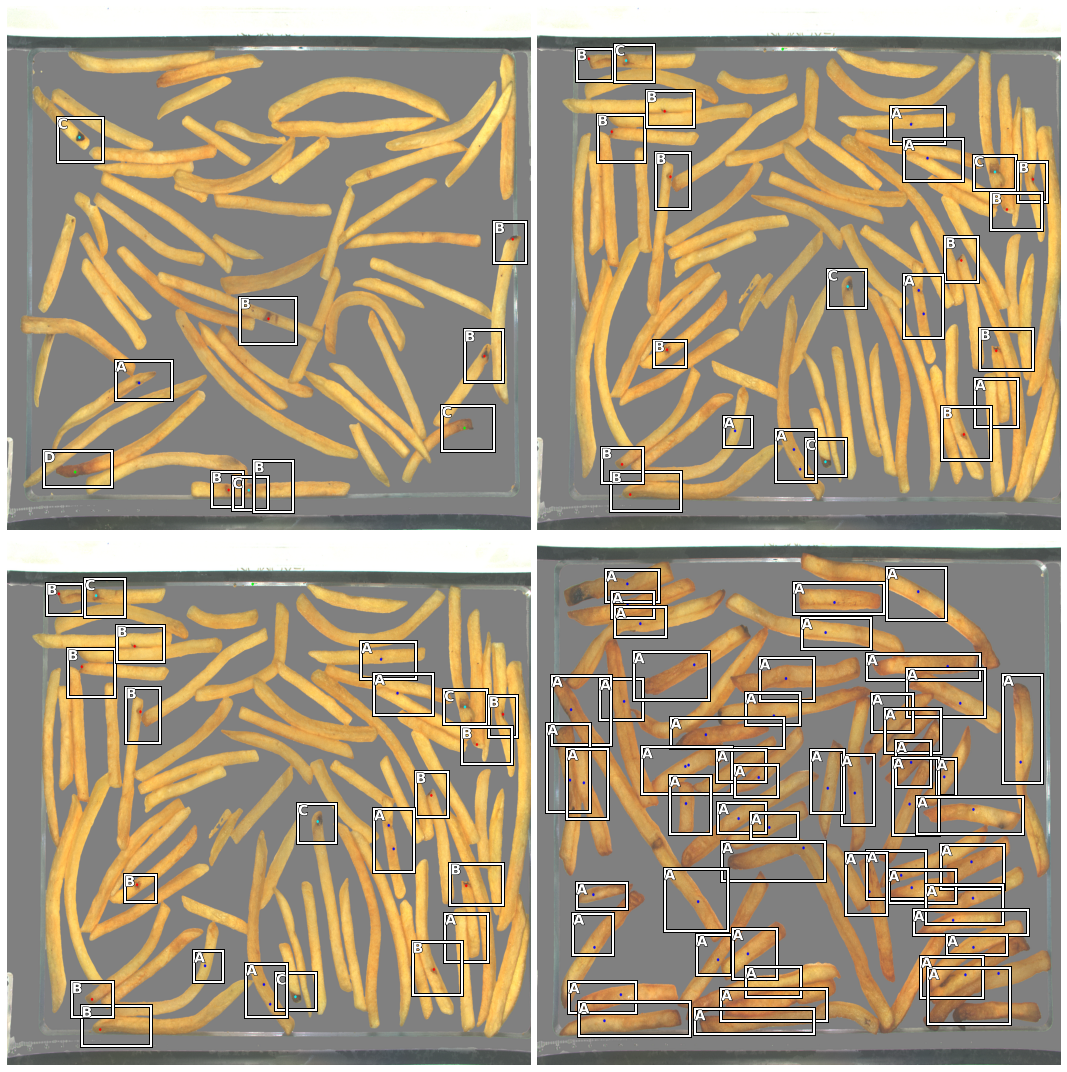

In [0]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))


# Create anchors and test them 

In [0]:
ratios = [0.5, 1, 2, 3]  # width/height
bh,bw = 32,32
sizes = [(bh,bw)]                                 # h,w
scales = [0.35, 0.5, 0.6]

nanchors = len(ratios)*len(scales) # 3*2*2*2
s = [bh]
chs = 125  # your RetinaNet starts off with these many channels

anchors = create_anchors(sizes= sizes, ratios= ratios,  scales= scales) 

len(anchors) 

# LOSS Function, incase you want to explore it yourself. but not needed here since it gets loaded from the imports cell

In [0]:
""" taken from RetinaNetFocalLoss.py to investigate """

from fastai import *
from fastai.vision import *
from torch.autograd import Variable

from object_detection_fastai.helper.object_detection_helper import *

class RetinaNetFocalLoss(nn.Module):

    def __init__(self, anchors: Collection[float], gamma: float = 2., alpha: float = 0.25, pad_idx: int = 0,
                 reg_loss: LossFunction = F.smooth_l1_loss):
        super().__init__()
        self.gamma, self.alpha, self.pad_idx, self.reg_loss = gamma, alpha, pad_idx, reg_loss
        self.anchors = anchors
        self.metric_names = ['BBloss', 'focal_loss']

    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt - self.pad_idx)) if sum(clas_tgt)>0 else 0
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:] - 1 + self.pad_idx

    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred)
        weights = Variable(encoded_tgt * (1 - ps) + (1 - encoded_tgt) * ps)
        alphas = (1 - encoded_tgt) * self.alpha + encoded_tgt * (1 - self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss

    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches >= 0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else:
            bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches >= 0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss, self._focal_loss(clas_pred, clas_tgt) / torch.clamp(bbox_mask.sum(), min=1.)

    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if bbox_tgts.device != self.anchors.device:
            self.anchors = self.anchors.to(clas_preds.device)

        bb_loss = torch.tensor(0, dtype=torch.float32).to(clas_preds.device)
        focal_loss = torch.tensor(0, dtype=torch.float32).to(clas_preds.device)
        for cp, bp, ct, bt in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts):
            bb, focal = self._one_loss(cp, bp, ct, bt)

            bb_loss += bb
            focal_loss += focal

        self.metrics = dict(zip(self.metric_names, [bb_loss / clas_tgts.size(0), focal_loss / clas_tgts.size(0)]))
        return (bb_loss+focal_loss) / clas_tgts.size(0)

class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()


In [0]:
criterion = RetinaNetFocalLoss(anchors)

# Encoder Architecture & its modifications

In [0]:
""" model = arch(pretrained)
 if cut is an int instance, this function returns the sequential list of the arch's children 
nn.Sequential(*list(model.children())[:cut]), 
if cut is a callable instance then it returns cut(model) 
cutting the last two in the case of resnet arch would be:
= == == == == == == == == == == == == == == == == == == == =
AdaptiveAvgPool2d(output_size=(1, 1))
= == == == == == == == == == == == == == == == == == == == =
Linear(in_features=512, out_features=1000, bias=True)
= == == == == == == == == == == == == == == == == == == =
which wouold be replaced by other components to ensure category classification and bbox regression is achieved""" 

encoder = create_body(arch = models.resnet50, pretrained= True, cut= -2)  #  resnet 18 , 34 , 50 ,  101

# RetinaNet instantiation

In [0]:
n_classes = 3 # background + other classes # data.train_ds.c

# for nanchors, chs, and s values see the cell with create_anchors() function

model = RetinaNet(encoder, n_classes= n_classes, n_anchors= nanchors, sizes= s, chs= chs, n_conv=2, final_bias= -4)

In [0]:
anchors[0] # why negative values for bbox???????????

tensor([-0.9688, -0.9688,  0.0875,  0.0875])

In [0]:
(data.valid_ds[0][0].data).shape

torch.Size([3, 1024, 1024])

In [0]:
for i, bbox in enumerate(anchors[:1]):
    print(bbox.shape)
    bb = bbox.numpy()
    print(bb.shape)
    print()
    x = (bb[0] + 1) * size / 2 
    print('x: ', x)
    y = (bb[1] + 1) * size / 2 
    print('y: ', y)
    w = bb[2] * size / 2
    print('w: ', w)
    h = bb[3] * size / 2
    print('j: ', h)

torch.Size([4])
(4,)

x:  16.0
y:  16.0
w:  31.678382873535156
j:  63.35676574707031


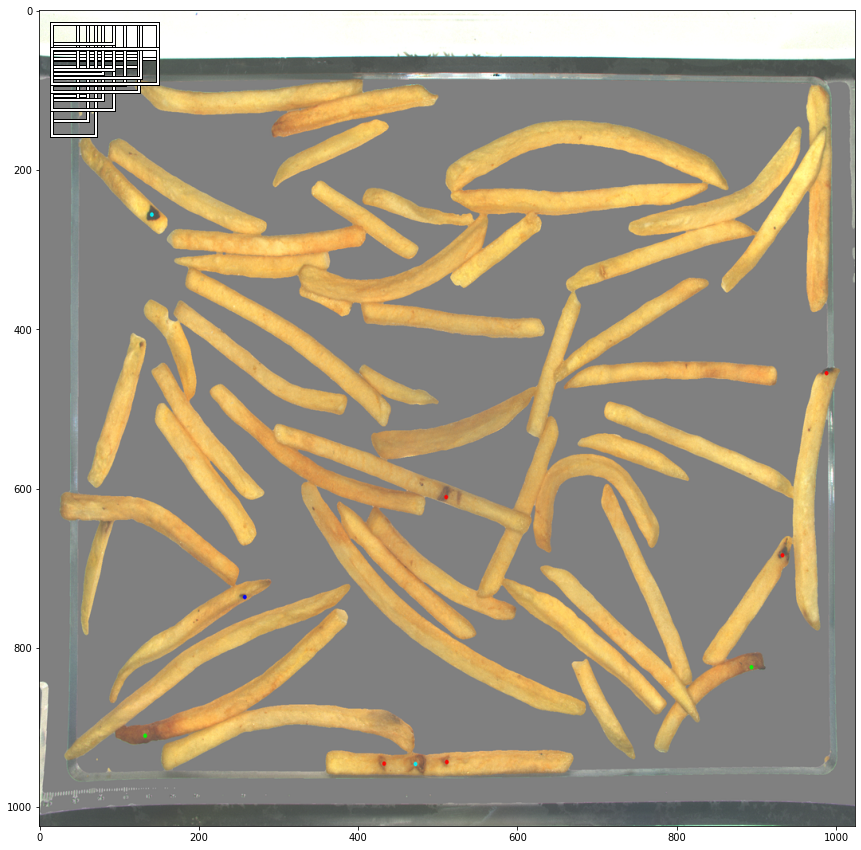

In [0]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:24]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

## The objects on the left side are covered by anchors, where the right side shoes the objects that would be missed in training

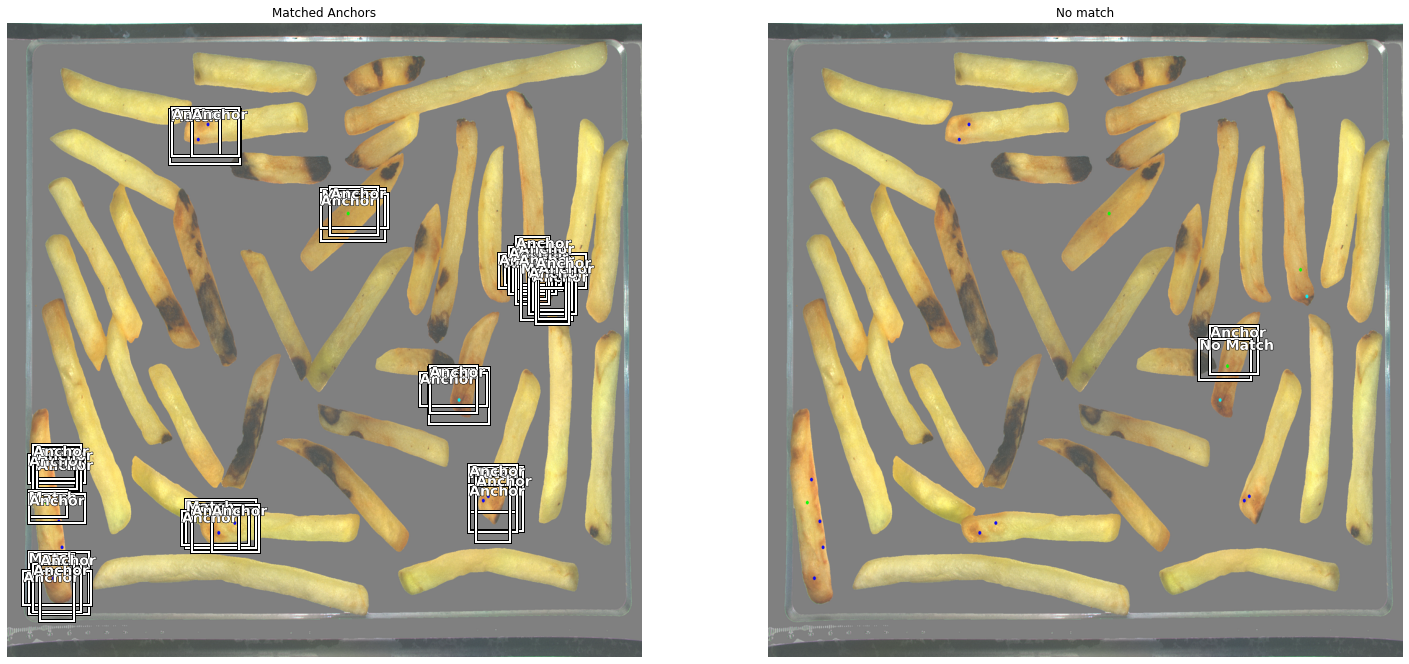

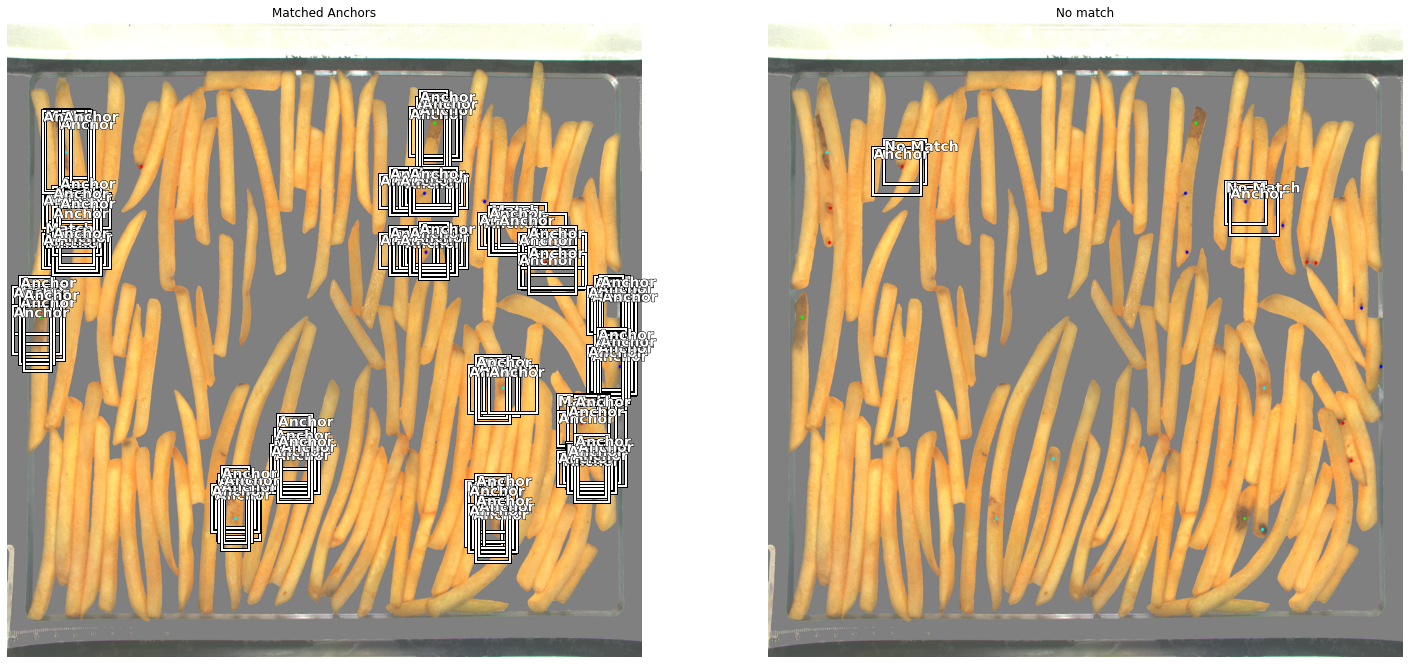

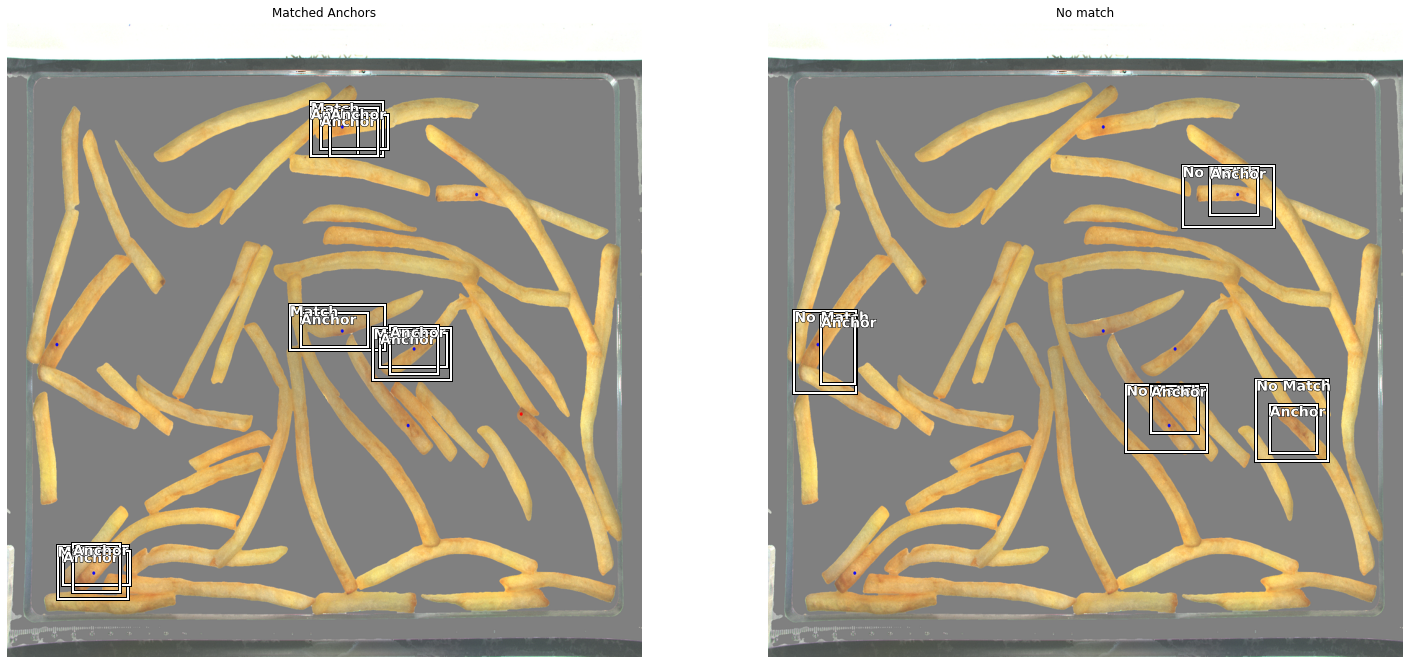

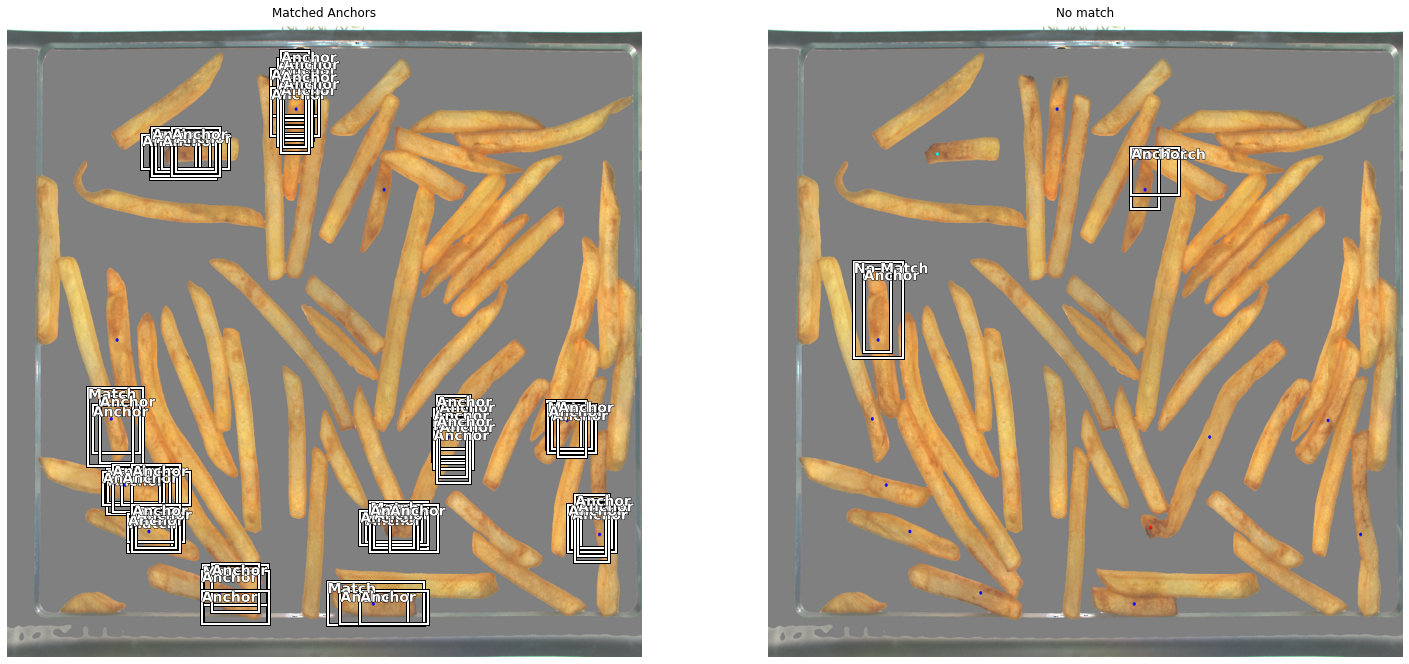

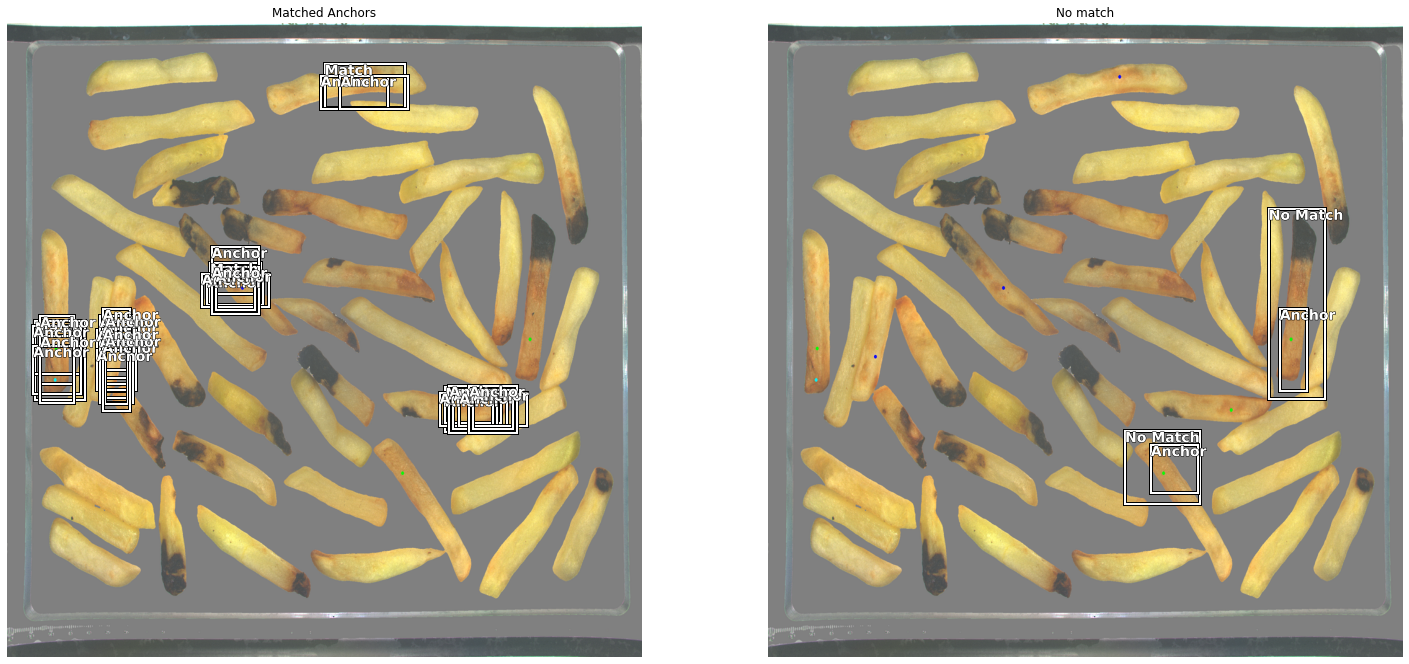

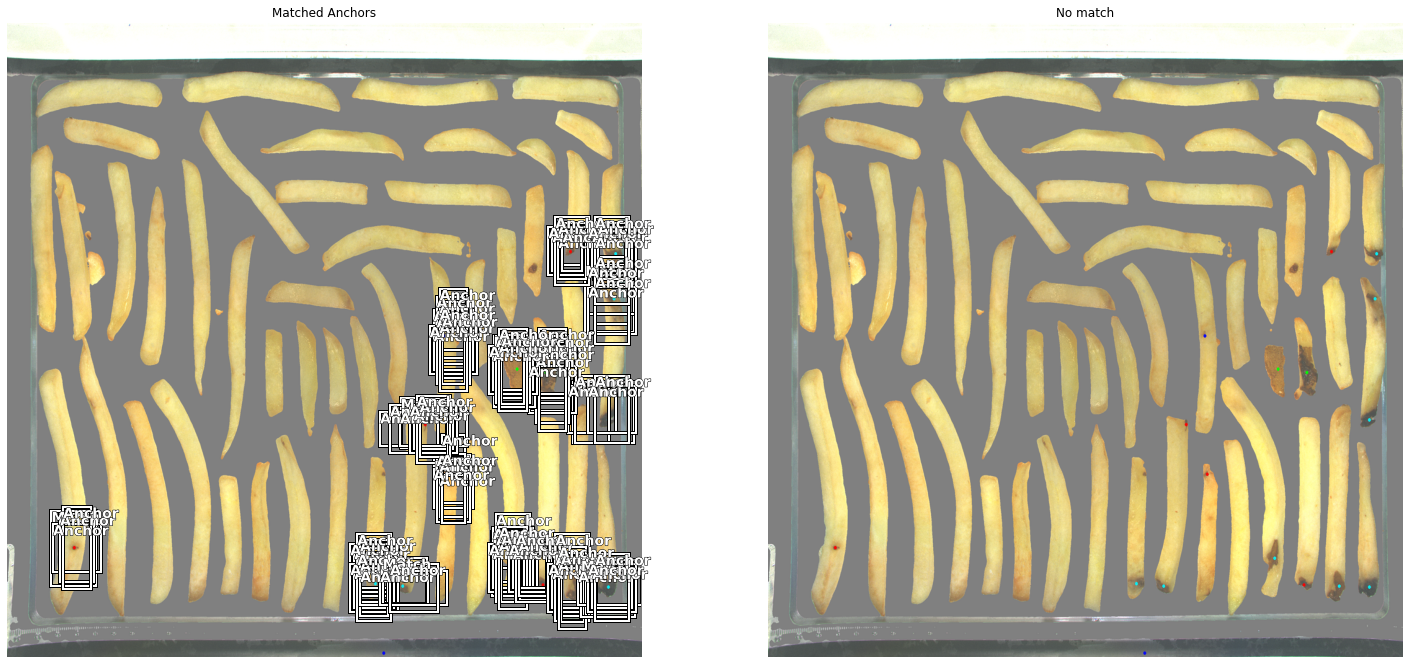

In [0]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

## This is a cleaner representation of model.eval()

In [0]:
def extract_all_layers(sequence, layers = []):
    for child in sequence.children():
        if isinstance(child, nn.Sequential): layers = extract_all_layers(child, layers)
        else: layers.append(child)
    return layers

lls = extract_all_layers(model)

In [0]:
lls

In [0]:
n_classes  # Background is the first class

5

In [0]:
data.train_ds.y.classes[1:] # zero index is fo the background

['A', 'B', 'C', 'D']

# Metrics, Non-Maximum-supression
# Learner

In [0]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func= criterion, callback_fns=[ShowGraph, BBMetrics], metrics=[voc])

In [0]:
learn.summary()

RetinaNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 512, 512]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 512, 512]       128        True      
______________________________________________________________________
ReLU                 [64, 512, 512]       0          False     
______________________________________________________________________
MaxPool2d            [64, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [64, 256, 256]       4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
Conv2d               [64, 256, 256]       36,864     True      
____________________________________________________

In [0]:
model.encoder

In [0]:
model.c5top5

In [0]:
learn.split([model.encoder[6], model.c5top5])

Learner(data=ImageDataBunch;

Train: LabelList (36 items)
x: ObjectItemList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ObjectCategoryList
ImageBBox (1024, 1024),ImageBBox (1024, 1024),ImageBBox (1024, 1024),ImageBBox (1024, 1024),ImageBBox (1024, 1024)
Path: /content/drive/My Drive/SM_datachallenges/DefectDetection/data/SM_sample;

Valid: LabelList (4 items)
x: ObjectItemList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ObjectCategoryList
ImageBBox (1024, 1024),ImageBBox (1024, 1024),ImageBBox (1024, 1024),ImageBBox (1024, 1024)
Path: /content/drive/My Drive/SM_datachallenges/DefectDetection/data/SM_sample;

Test: None, model=RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Ma

In [0]:
""" you can see these category classifier and bounding box regressor layers at the end of your model shown above"""
  """
  (classifier): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Conv2d(512, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (box_regressor): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Conv2d(512, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  """

In [0]:
# learn.summary()

In [0]:
learn.freeze_to(-2)

In [0]:
learn.lr_find()
learn.recorder.plot()

Detections: 0it [00:00, ?it/s]
Detections: 100%|██████████| 4/4 [00:00<00:00, 13127.71it/s]
GT: 0it [00:00, ?it/s]


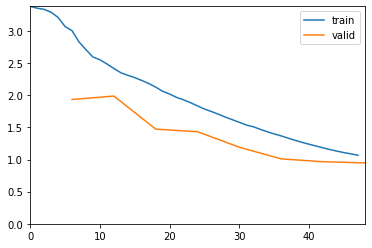

GT: 100%|██████████| 29/29 [00:00<00:00, 47420.98it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 11/11 [00:00<00:00, 7582.14it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 29/29 [00:00<00:00, 29295.48it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 11/11 [00:00<00:00, 11642.02it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 29/29 [00:00<00:00, 16183.45it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 11/11 [00:00<00:00, 23527.46it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 1/1 [00:00<00:00, 1188.86it/s]


In [0]:
learn.fit_one_cycle(8, slice(1e-3/(3.6**4),1e-3), moms=(0.8,0.7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


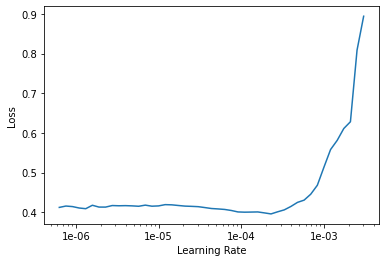

In [0]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 11/11 [00:00<00:00, 25420.02it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 1/1 [00:00<00:00, 5482.75it/s]


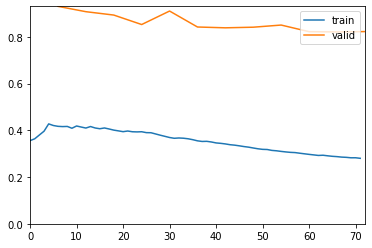

GT: 100%|██████████| 11/11 [00:00<00:00, 26980.90it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 1/1 [00:00<00:00, 3261.51it/s]


In [0]:
learn.freeze_to(-4) # unfreezing the last ...
learn.fit_one_cycle(12, slice(1e-4/(3.6**4),1e-4), moms=(0.8,0.7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


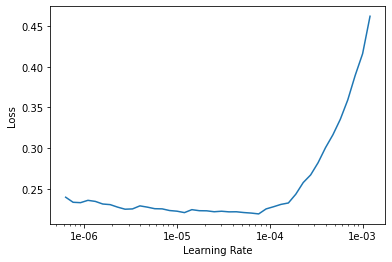

In [0]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 1/1 [00:00<00:00, 4821.04it/s]


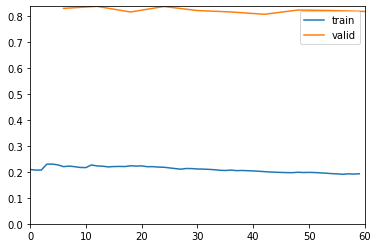

GT: 100%|██████████| 1/1 [00:00<00:00, 2584.29it/s]


In [0]:
learn.freeze_to(-8) # unfreezing the last...
learn.fit_one_cycle(10, slice(6e-5/(3.6**4),6e-5), moms=(0.8,0.7))

GT: 100%|██████████| 1/1 [00:00<00:00, 1859.18it/s]


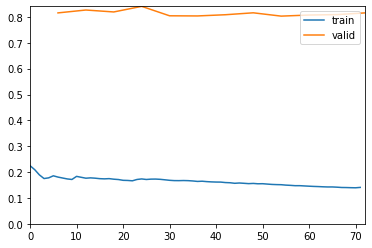

GT: 100%|██████████| 1/1 [00:00<00:00, 2904.64it/s]


In [0]:
learn.unfreeze()
learn.fit_one_cycle(12, slice(6e-5/(3.6**4),6e-5), moms=(0.8,0.7))

In [0]:
data.train_ds.classes

['background', 'A', 'B', 'C', 'D']

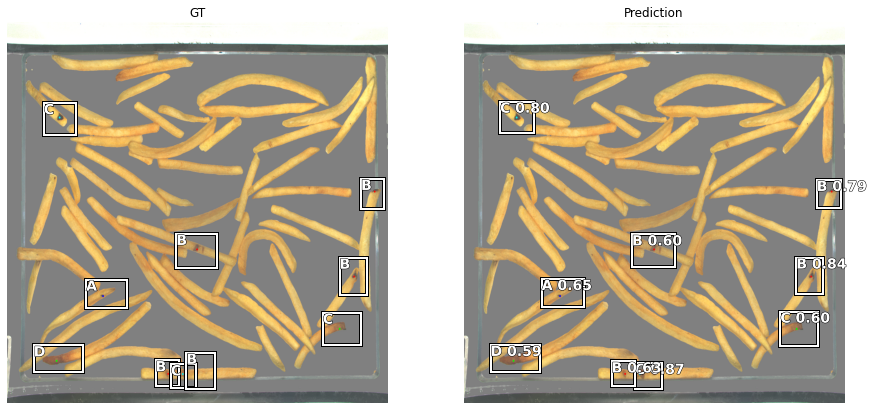

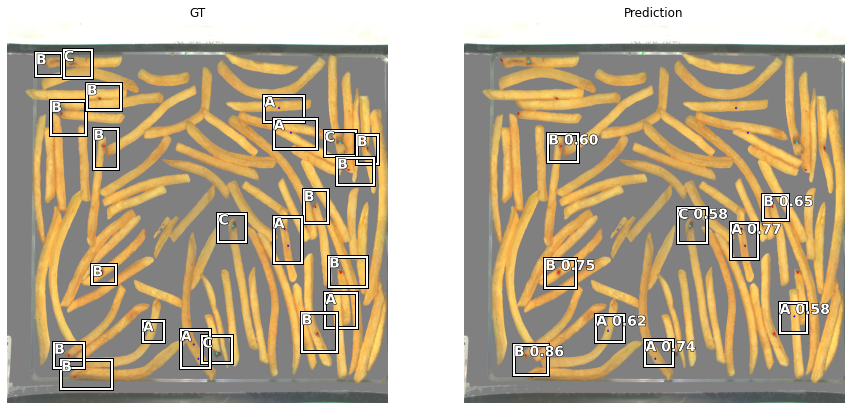

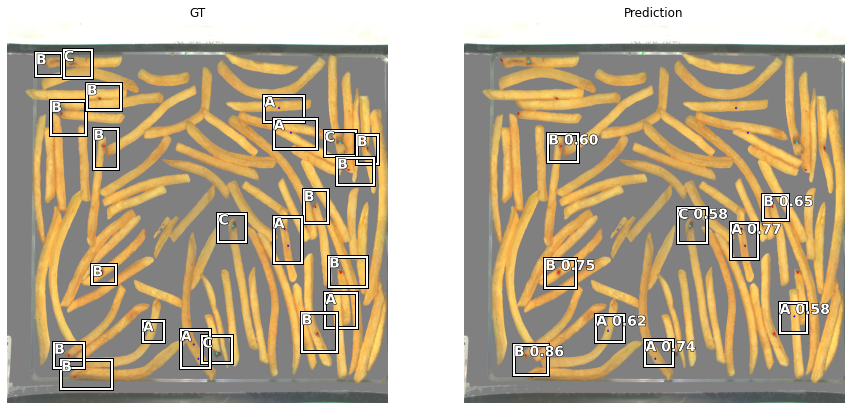

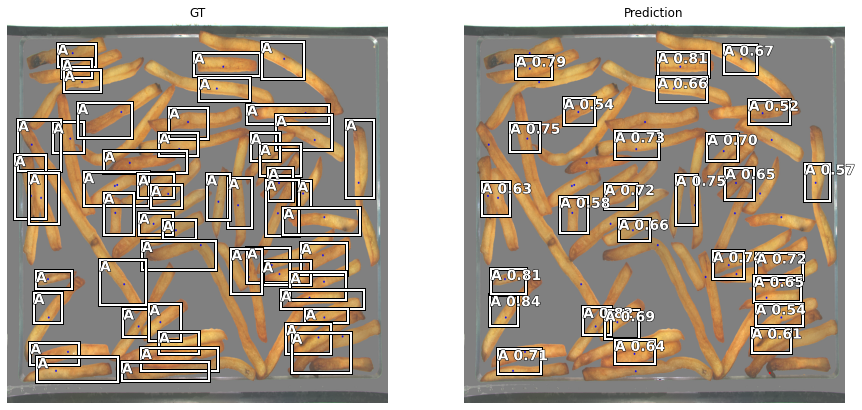

In [0]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=5)